In [13]:
from bgs import *

<AxesSubplot:>

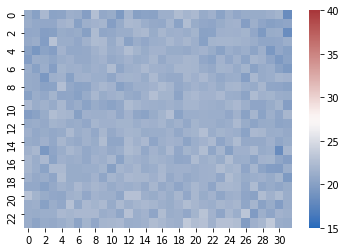

In [46]:
sns.heatmap(data[103,:,:,14] , cmap="vlag" , vmin=15 ,vmax=40)
